In [22]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [23]:
import matplotlib.pyplot as plt
import numpy as np
#import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [24]:
data_dir = "D:/Tensorflow_projects/Disertatie/Clase"
#print(type(data_dir))
batch_size = 32
img_height = 180
img_width = 180

In [25]:
dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  #subset = "training",
  #validation_split = 0.3,
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size)

Found 675 files belonging to 2 classes.


In [26]:
dataset_size = len(dataset)
train_split = 0.7
validation_split = 0.2
test_split = 0.1

train_size = int(dataset_size * train_split)
validation_size = int(dataset_size * validation_split)
test_size = dataset_size - train_size - validation_size

print(dataset_size, train_size, validation_size, test_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(validation_size)
test_ds = dataset.skip(train_size + validation_size).take(test_size)
len(test_ds)

22 15 4 3


3

In [27]:
class_names = dataset.class_names
print(class_names)
print(type(dataset))
print(type(train_ds))
print(train_ds.element_spec)
print(dataset.element_spec)

['0', '1']
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.take_op._TakeDataset'>
(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


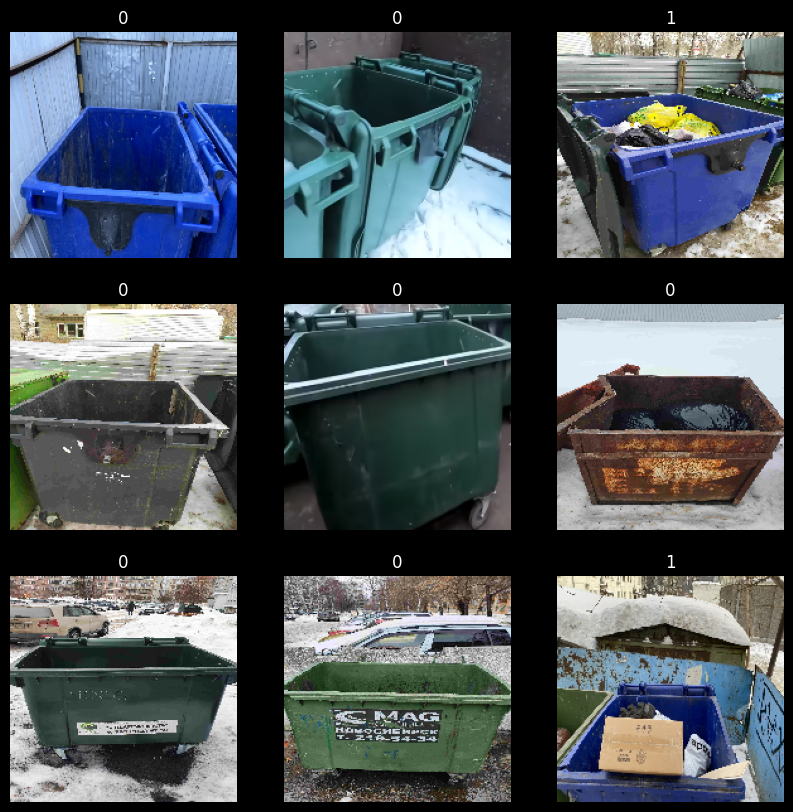

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, reshuffle_each_iteration = True).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

d:\Tensorflow_projects\Disertatie\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


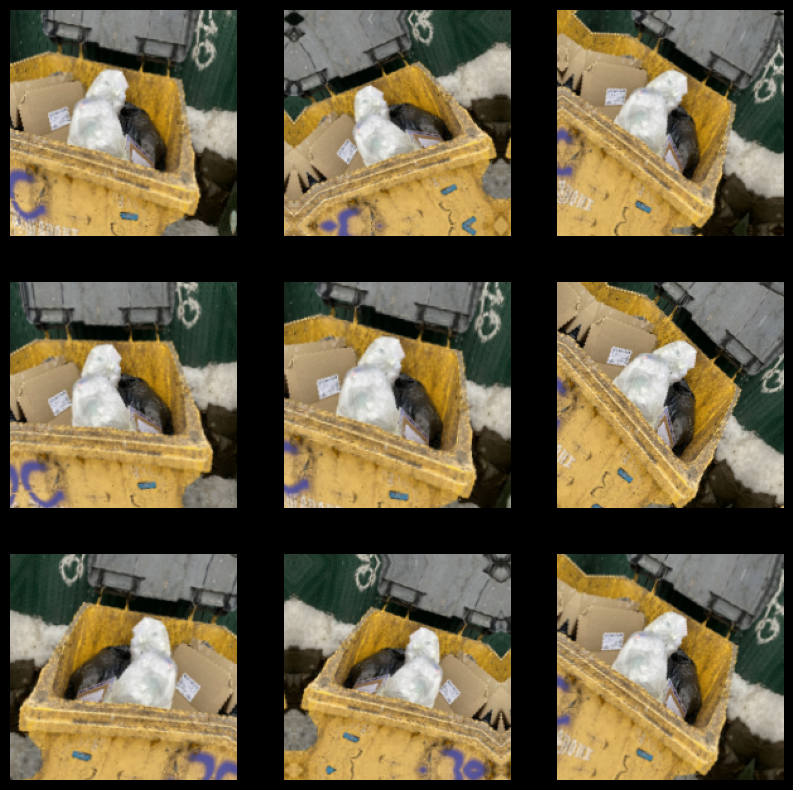

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [41]:
encoder = (
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D()
)

bottleneck = (
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(256)
)

decoder = (
    layers.Reshape((4, 4, 16)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.UpSampling2D(2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.UpSampling2D(2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.UpSampling2D(2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.UpSampling2D(2)
)

In [51]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  #encoder,
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #bottleneck
  layers.Flatten(),
  layers.Dense(128),
  layers.Dense(256),
  #decoder
  layers.Reshape((4, 4, 16)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.UpSampling2D(2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.UpSampling2D(2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.UpSampling2D(2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.UpSampling2D(2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
import os
results_dir = f"{os.getcwd()}/encoder-decoder_results"

#summary = model.summary()

#with open(f"{results_dir}/summary", 'w') as file:
#    file.write(f"{summary}")

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 180, 180, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 90, 90, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 45, 45, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 22, 22, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_18 (UpSampling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_19 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    67,108,99

 Total params: 67,589,986 (257.84 MB)

 Trainable params: 67,589,986 (257.84 MB)

 Non-trainable params: 0 (0.00 B)

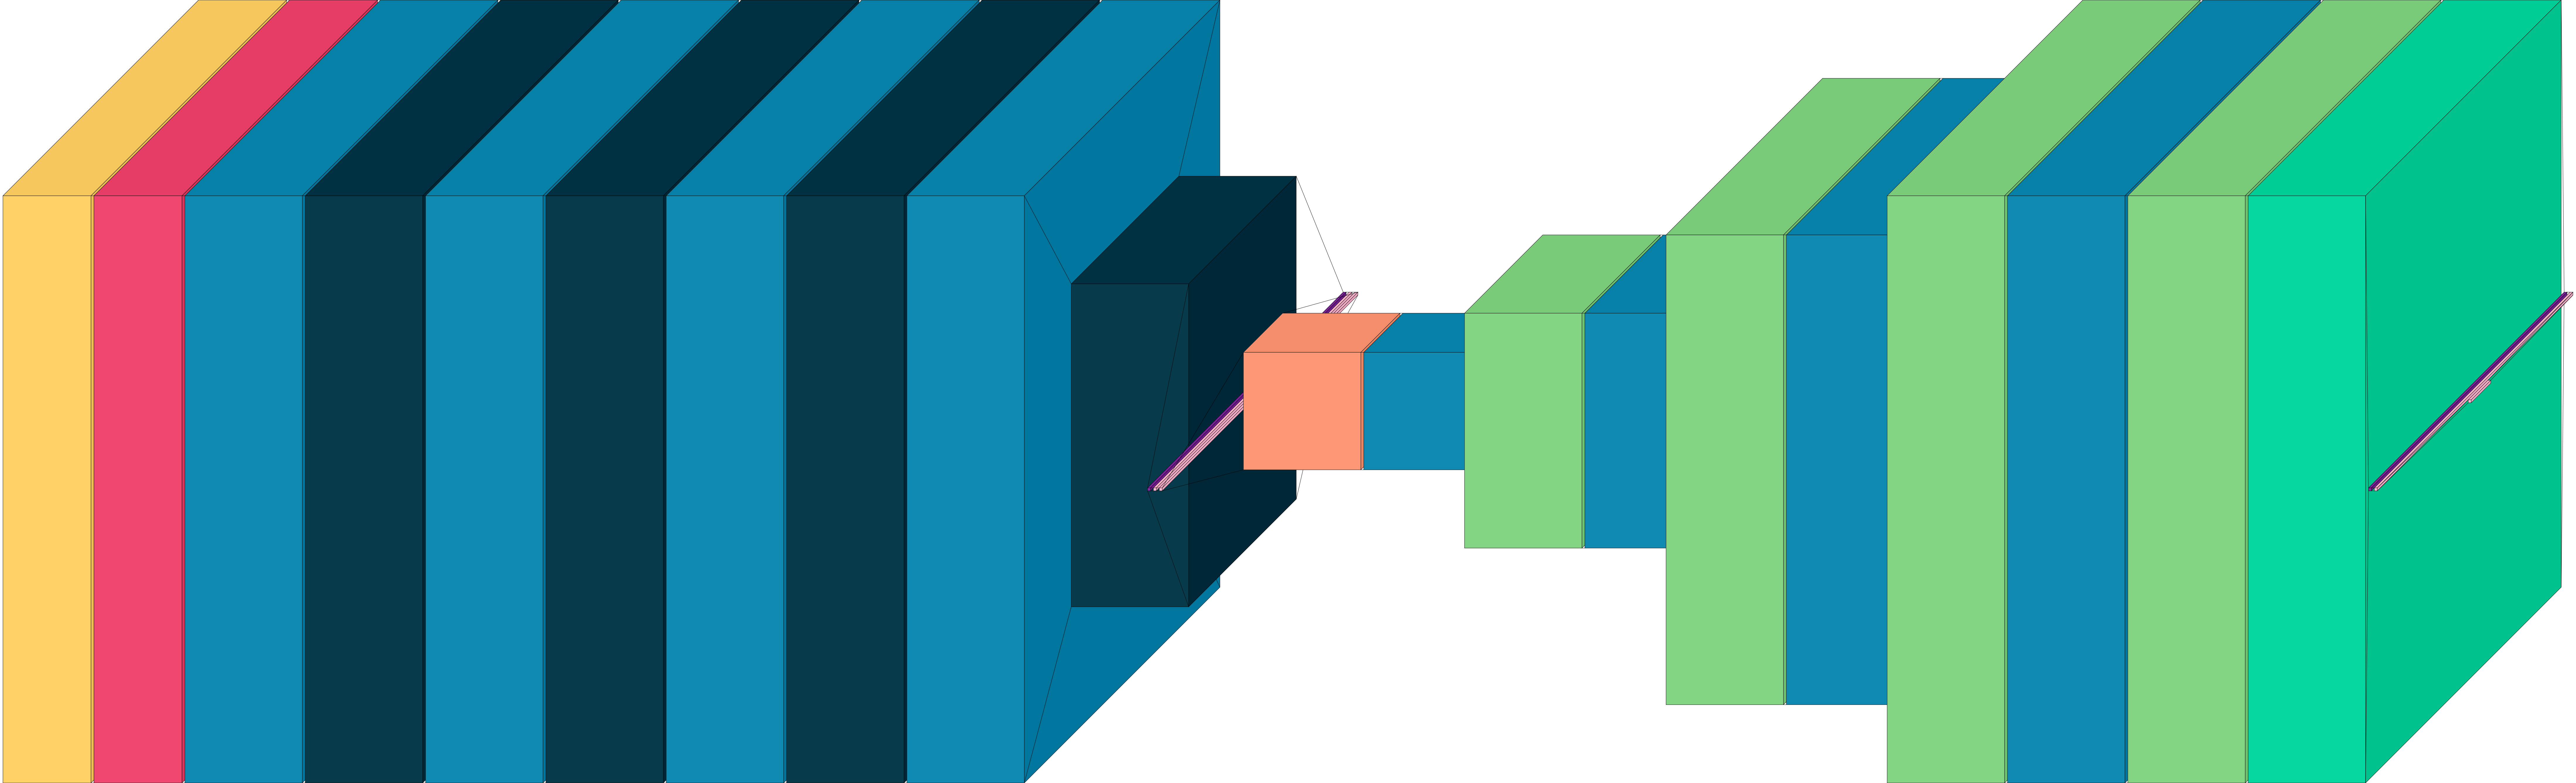

In [54]:
import visualkeras
visualkeras.layered_view(model = model,to_file = f"{results_dir}/model_structure.png", min_xy=10, min_z=10, scale_xy=100, scale_z=100, one_dim_orientation='x')

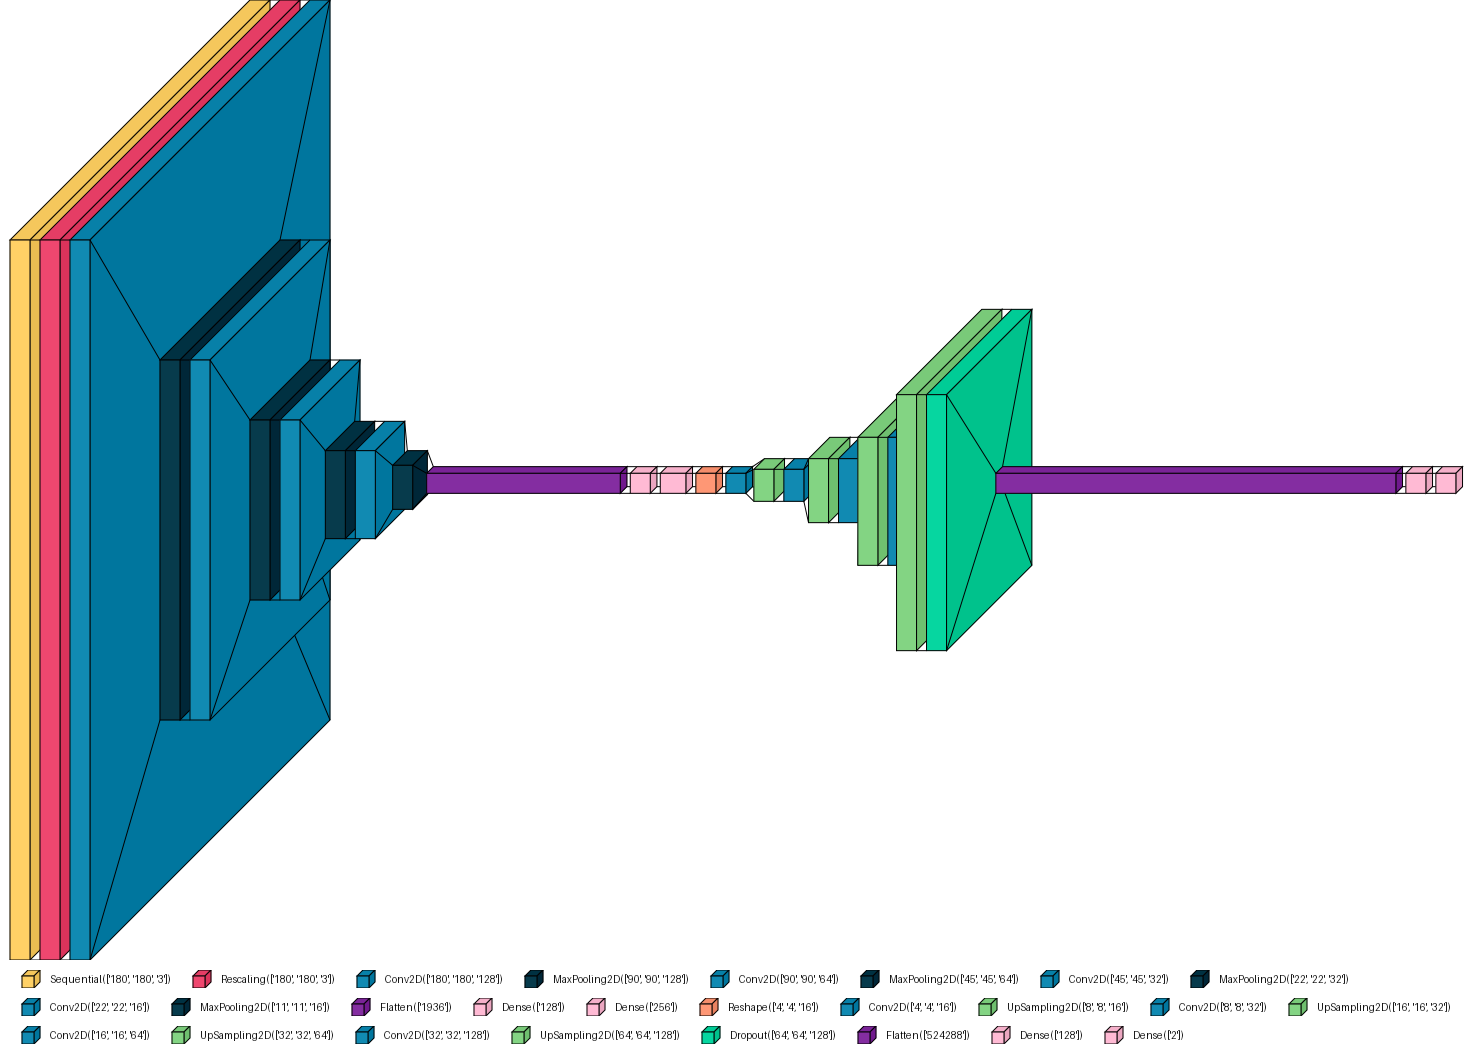

In [55]:
visualkeras.layered_view(model = model,to_file = f"{results_dir}/model_structure2.png", legend = True, show_dimension = True)

In [56]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5382 - loss: 0.8576 - val_accuracy: 0.6250 - val_loss: 0.6782
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5976 - loss: 0.6736 - val_accuracy: 0.6250 - val_loss: 0.6550
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6141 - loss: 0.6522 - val_accuracy: 0.7266 - val_loss: 0.5586
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5496 - loss: 0.6712 - val_accuracy: 0.6250 - val_loss: 0.6883
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6086 - loss: 0.6857 - val_accuracy: 0.7891 - val_loss: 0.6373
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7032 - loss: 0.6127 - val_accuracy: 0.5312 - val_loss: 0.6752
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6674 - loss: 0.5839 - val_accuracy: 0.6719 - val_loss: 0.5634
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6799 - loss: 0.5939 - val_accuracy: 0.7812 - val_loss:

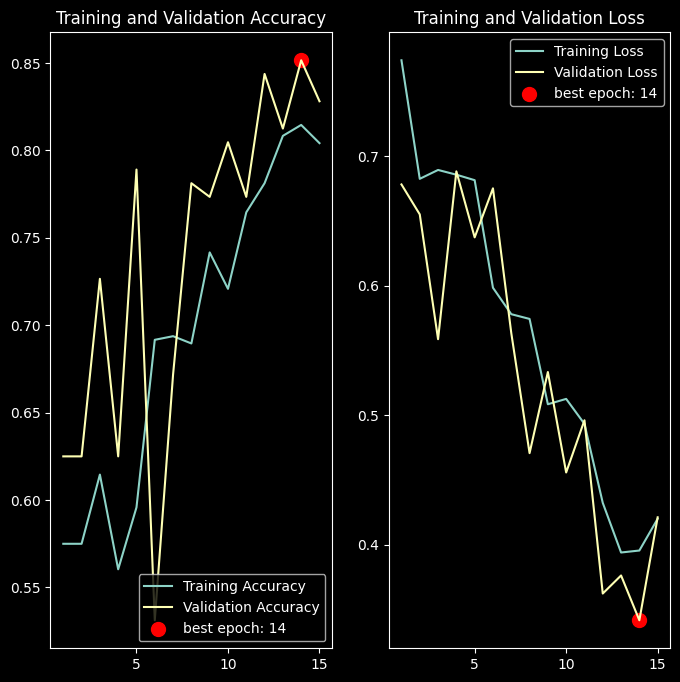

<Figure size 640x480 with 0 Axes>

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = [x + 1 for x in range(epochs)]
index_min_loss = np.argmin(val_loss)
val_min_loss = val_loss[index_min_loss]
index_max_acc = np.argmax(val_acc)
val_max_acc = val_acc[index_max_acc]
min_loss_label = f"best epoch: {index_min_loss + 1}"
max_acc_label = f"best epoch: {index_max_acc + 1}"

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.scatter(index_max_acc + 1, val_max_acc, c = 'red',s = 100, label = max_acc_label)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.scatter(index_min_loss + 1, val_min_loss, c =  "red", s = 100, label = min_loss_label)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig(f"{results_dir}/train_validation_history.png")

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

test_ds_true_labels = []
test_ds_predicted_labels = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis = 1)

    test_ds_predicted_labels.extend(predicted_labels)
    test_ds_true_labels.extend(label_batch)

#convert to numpy array
test_ds_true_labels = np.array(test_ds_true_labels)
test_ds_predicted_labels = np.array(test_ds_predicted_labels)

con_mat = confusion_matrix(test_ds_true_labels, test_ds_predicted_labels)

report = classification_report(test_ds_true_labels,test_ds_predicted_labels, target_names= class_names)

with open(f"{results_dir}/report", "w") as file:
    file.write(report)
    
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
              precision    recall  f1-score   support

           0       0.66      0.85      0.74        27
           1       0.88      0.70      0.78        40

    accuracy                           0.76        67
   macro avg       0.77      0.78      0.76        67
weighted avg       0.79      0.76      0.76        67



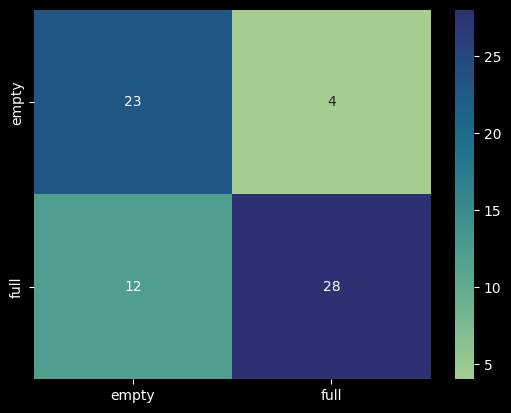

In [61]:
import seaborn as sns

class_names_dict = {0: "empty", 1: "full"}

heatmap = sns.heatmap(con_mat, annot = True, cmap = "crest", xticklabels= class_names_dict.values(), yticklabels= class_names_dict.values())

#heatmap.savefig(f"{os.getcwd()}/cnn1_results/confusion_matrix.png")
fig = heatmap.get_figure()
#fig = heatmap.fig
fig.savefig(f"{results_dir}/confusion_matrix.png")

In [62]:
model.save(filepath= f"{results_dir}/encoder-decoder_model.keras")